# Goals
The primary goal of this notebook is to revisit the Dengue fever epidemic study and try more techniques. These include:
* Using PyTorch instead of TensorFlow
* Trying RNNs (GRU and LSTM) and/or CNN
    * This will likely require reworking how the input data is formatted
    

For reference: the previous versions:
https://www.kaggle.com/code/michaeloliver137/dengue-study-v3
https://www.kaggle.com/code/michaeloliver137/dengue-study-v2
https://www.kaggle.com/code/michaeloliver137/dengue-study

# Notes on the Data Source

The dataset on Kaggle has defined training and testing datasets, with labels (the total weekly cases of Dengue) only for the training set. Thus, the test set can't be used locally, especially if we are using the time series of cases as a feature.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [2]:
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True)
#dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True)


In [4]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


# Cleaning the data
* This dataset has an issue with an inconsistency in how the dates and week number are encoded, which need to be corrected.
* For simplicity, the data will be converted to an index of the number of weeks since a given starting point

In [5]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()

# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']


    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
#dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
#dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
#dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])

list_of_frames=[
    dengue_features_sj_train,
#    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
 #   dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)


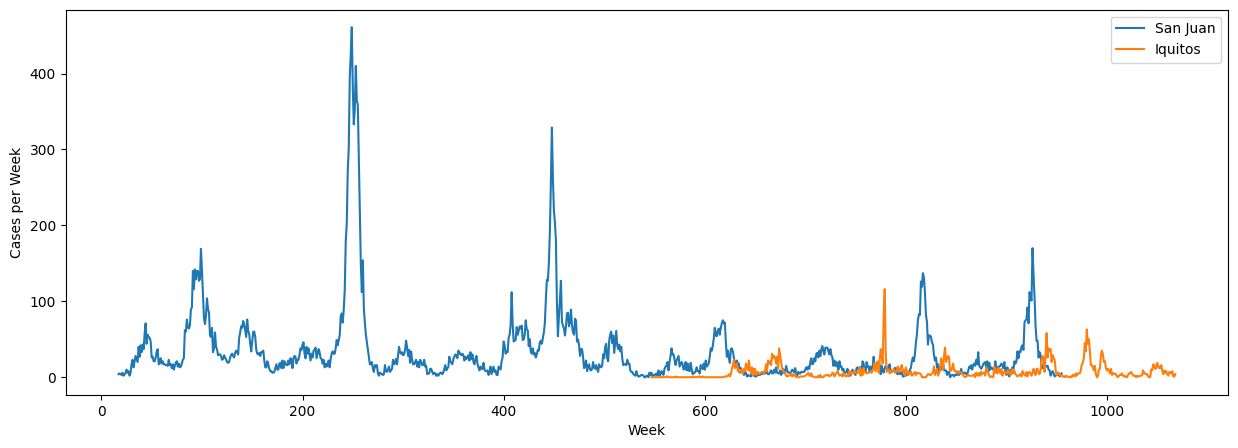

In [6]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('cases_data.png')

/tmp/ipykernel_19/813398954.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((len(features_to_plot), 1), (0, 0), colspan=1)
/tmp/ipykernel_19/813398954.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
/tmp/ipykernel_19/813398954.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
/tmp/ipykernel_19/813398954.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases la

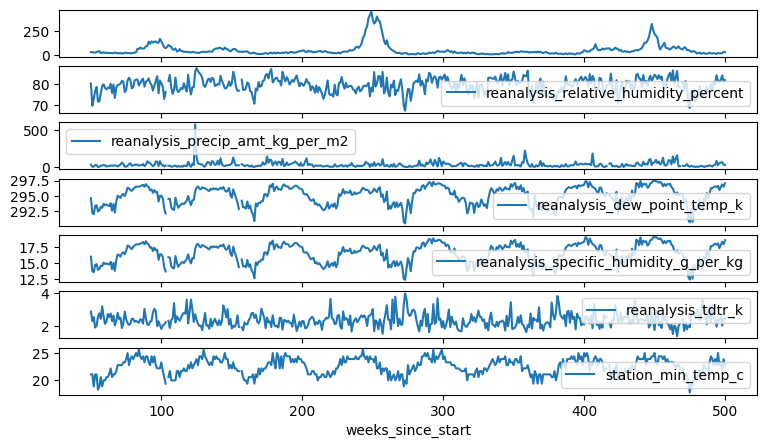

In [7]:
start_week=50
end_week=500

features_to_plot=['total_cases',
                  'reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, sharex=True, sharey=False,figsize=(15,8))
for i in range(len(features_to_plot)):
    feat_to_plot = features_to_plot[i]
    if feat_to_plot == 'total_cases':
        figsize=(9,5)
        ax1 = plt.subplot2grid((len(features_to_plot), 1), (0, 0), colspan=1)
        dengue_labels_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax1,figsize=figsize)
    else:
        ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
        dengue_features_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax2,label=feat_to_plot)
        ax2.legend()

In [8]:
dengue_features_sj_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

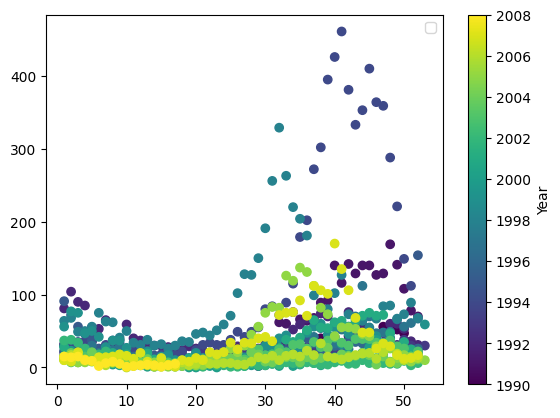

In [9]:
figs, ax = plt.subplots()
scatter_plot = ax.scatter(dengue_features_sj_train['weekofyear'],dengue_labels_sj_train['total_cases'],
                          c=dengue_features_sj_train['year'],cmap='viridis',marker='o')
plt.colorbar(scatter_plot, label='Year')
ax.legend()

# Partial Auto Correlation 
Using the Partial Auto-Correlation computation to show the strong auto-correlation and give an estimate of how long the time-dependence is.

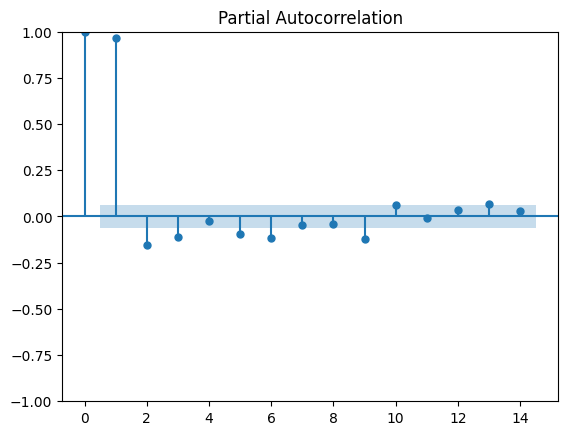

In [10]:
#from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('cases_sj_pacf.png')

In [11]:
dengue_features_sj_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
18,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
19,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
20,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
21,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


# Target
The goal is to predict future rates of Dengue. We can start by making predictions for a specific number of weeks in the future, and maybe expand that to multi-week targets, like done in previous versions of this study.

In [12]:
num_target_lags = 10

#y_sj = dengue_features_sj_train[]
#y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=target_lag_number)
y_sj = pd.concat({ f"y_step_{i}":dengue_labels_sj_train['total_cases'].shift(-i) for i in range(1,num_target_lags+1)},axis=1)
#.DataFrame({f"target_lead})
y_sj

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
weeks_since_start,,,,,,,,,,
17,5.0,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0
18,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0
19,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0
20,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0,17.0
21,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0,17.0,23.0
...,...,...,...,...,...,...,...,...,...,...
951,3.0,1.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
952,1.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should remember to remove rows with NaN later.

In [13]:
#Not_NaN_rows = y_sj.hasnans()
Not_NaN_rows  = y_sj.dropna().index
print(Not_NaN_rows)
#print(y_sj.iloc[Not_NaN_rows])

Index([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
       ...
       936, 937, 938, 939, 940, 941, 942, 943, 944, 945],
      dtype='int64', name='weeks_since_start', length=926)


# Features to Train on

The variables of interest, except perhaps the dates, are all floating point variables. For the dates, it might be of interest to add fourier features to directly include seasonality. The relative utility of this might be limited by the fact that many of of the physical variables are essentially already fourier features, and may be more directly connected to the physical causes of seasonality.

We will also include the Dengue fever rates for each time, from the labels. 

In [14]:
#dengue_features_sj_train.columns[dengue_features_sj_train.dtypes.str.contains('float')]

features_to_train = dengue_features_sj_train.select_dtypes(include="float").columns.tolist()
print(features_to_train)

['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


In [15]:
#features_to_train = []
primary_data_sj = dengue_features_sj_train[features_to_train]
primary_data_sj = pd.concat([dengue_labels_sj_train['total_cases'],primary_data_sj],axis=1)
primary_data_sj

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,4,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
18,5,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
19,4,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
20,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
21,6,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,4,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
952,3,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
953,1,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7


In [16]:
y_sj

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
weeks_since_start,,,,,,,,,,
17,5.0,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0
18,4.0,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0
19,3.0,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0
20,6.0,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0,17.0
21,2.0,4.0,5.0,10.0,6.0,8.0,2.0,6.0,17.0,23.0
...,...,...,...,...,...,...,...,...,...,...
951,3.0,1.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
952,1.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
primary_data_sj = primary_data_sj.loc[Not_NaN_rows]
y_sj = y_sj.loc[Not_NaN_rows]

# Train-Test Split

In [18]:
test_size = 400

X_train, X_valid, y_train, y_valid = train_test_split(primary_data_sj,y_sj,test_size=test_size,shuffle=False)



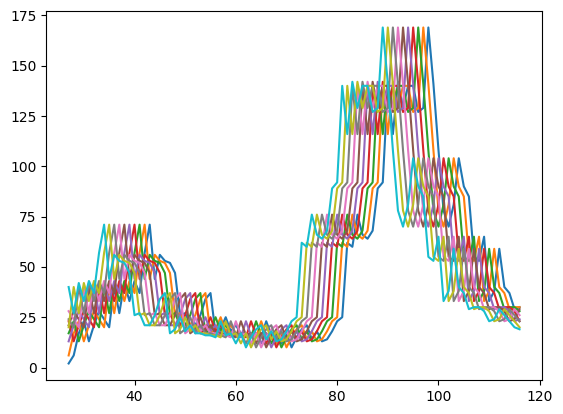

In [19]:
plt.plot(y_train.iloc[10:100])

# Feature Engineering

Normalize the data using the training set

In [20]:
X_train_mean = X_train.mean()
X_train_std  = X_train.std()

X_train = (X_train - X_train_mean) / X_train_std
X_valid = (X_valid - X_train_mean) / X_train_std

X_train.fillna(0,inplace=True)
X_valid.fillna(0,inplace=True)

X_train.head(16)

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,-0.653411,0.380536,0.071450,0.437184,0.208036,-0.532889,-1.141354,-1.112617,-1.611705,-1.129951,...,-0.065785,-1.688286,-0.532889,-1.539157,0.615891,-1.132565,-0.011544,-1.394782,-1.657792,-0.324041
18,-0.637531,0.890870,0.569882,-0.253805,-0.205905,-0.277468,-0.590549,-0.498287,-0.654455,-0.202538,...,-0.417082,-0.552804,-0.277468,-0.679824,0.032827,-0.223201,-0.632593,-0.027224,-0.218022,-0.588258
19,-0.653411,-0.594278,0.969039,-0.352445,0.081338,0.010371,-0.098892,-0.115898,0.268989,-0.539779,...,-0.213200,0.775977,0.010371,0.252624,-0.129135,-0.223201,-0.498312,0.270072,0.174643,0.582869
20,-0.669290,0.445631,1.903681,0.993281,1.297907,-0.460683,0.078548,0.191267,0.191591,0.219013,...,-0.518024,0.289284,-0.460683,0.141597,0.162397,0.318330,-0.162610,0.924121,0.501864,-0.752502
21,-0.621652,1.174629,2.125782,1.445500,1.512149,-0.653231,0.536936,0.573655,0.510081,0.640564,...,-0.560499,0.324134,-0.653231,0.480997,1.490488,1.370740,2.892281,1.934925,0.894528,-0.688233
22,-0.685170,0.000000,0.993453,1.505068,0.285213,-0.602638,0.633049,0.661417,0.528763,1.062115,...,-0.203456,0.162849,-0.602638,0.482802,-0.582630,0.778121,0.038812,1.578171,0.894528,0.500747
23,-0.653411,0.275880,-0.070172,0.563195,0.818813,-0.752452,0.268311,0.184998,0.537660,0.134703,...,0.099119,0.760983,-0.752452,0.496342,-0.712200,0.277460,-0.162610,0.270072,0.501864,0.165119
24,-0.637531,-0.160008,-0.333324,-0.462016,-0.625946,2.873537,0.599779,0.454551,0.952231,-0.455469,...,-0.115756,1.151229,2.873537,0.965725,-1.781151,0.962037,0.911638,1.280875,0.174643,-0.141945
25,-0.558134,0.163131,0.621735,-0.957408,-0.802299,-0.363427,0.588689,0.479625,0.857040,0.809184,...,0.071885,0.979002,-0.363427,0.847477,-1.068517,0.931384,0.559150,1.280875,0.174643,-0.141945


# Build Batches for model

In [21]:
X_train.head(1)

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,-0.653411,0.380536,0.07145,0.437184,0.208036,-0.532889,-1.141354,-1.112617,-1.611705,-1.129951,...,-0.065785,-1.688286,-0.532889,-1.539157,0.615891,-1.132565,-0.011544,-1.394782,-1.657792,-0.324041


In [22]:
X_train.iloc[2:3,:]

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
19,-0.653411,-0.594278,0.969039,-0.352445,0.081338,0.010371,-0.098892,-0.115898,0.268989,-0.539779,...,-0.2132,0.775977,0.010371,0.252624,-0.129135,-0.223201,-0.498312,0.270072,0.174643,0.582869


In [23]:
input_size = X_train.shape[1]
X_train.shape

(526, 21)

In [24]:
class MyDataLoader:
    def __init__(self,data_source,label_source,batch_size=16,randomize_start=False):
        # data_source should be a data-frame
        self.data = data_source
        self.labels = label_source
        self.batch_size = batch_size
        self.randomize_start = randomize_start
        
    def __iter__(self):
        if self.randomize_start:
            self.current_index = torch.randint(low=0, high=self.batch_size, size=(1,)).item()
        else:
            self.current_index = 0
        return self
        
    def __len__(self):
        return int(self.data.shape[0] / self.batch_size)
        
    def __next__(self):        
        local_index = self.current_index

        if local_index + self.batch_size > self.data.shape[0]:
            # reset
            self.current_index = 0
            raise StopIteration
        
        self.current_index += self.batch_size
        result_data = self.data.iloc[local_index:local_index + self.batch_size]
        tensor_data = torch.tensor(result_data.values, dtype=torch.float32)
        
        result_label = self.labels.iloc[local_index:local_index + self.batch_size]
        tensor_label = torch.tensor(result_label.values, dtype=torch.float32)
        
        # does this need to be grad enabled?
        return tensor_data,tensor_label
        

In [25]:
# testing data loader
data_loader = MyDataLoader(X_train,y_train,batch_size=16,randomize_start=False)
count = 0
num_batches = 0

for batch in data_loader:
    data,label = batch
    print(data.shape,label.shape)
    num_batches += 1

next_batch = next(data_loader)
data,label = next_batch
print(data)
print(label)

torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([16, 10])
torch.Size([16, 21]) torch.Size([1

# Building Models

In [26]:
debug_nn = False


class MyNetwork_Basic(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()

        # add a standard dense block with similar number of parameters to RNN in MyNetwork
        #self.block1 = nn.Sequential(
        #    nn.Linear(input_size,128),
        #    nn.ReLU(),
        #    nn.Linear(128,32),
        #    nn.ReLU()
        #) 
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,output_size),
        )
    def forward(self,x):
        #x = self.block1(x)
        if (debug_nn):
            print(x.shape)
        x = self.linear_relu_stack(x)
        if (debug_nn):
            print(x.shape)
        #x = F.relu(x) # because the output is non-negative
        return x

class MyNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        
        self.lstm1 = nn.LSTM(input_size,32,num_layers=2)
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,output_size),
        )
    def forward(self,x):
        if (debug_nn):
            print(x.shape)
        x, (h_n, c_n) = self.lstm1(x)
        if (debug_nn):
            print(x.shape)
        x = self.linear_relu_stack(x)
        if (debug_nn):
            print(x.shape)
        return x

In [27]:
torch.manual_seed(0)
print(input_size,num_target_lags)
model = MyNetwork(input_size,num_target_lags).to(device)
#model = MyNetwork_Basic(input_size,num_target_lags).to(device)
print(model)

21 10
MyNetwork(
  (lstm1): LSTM(21, 32, num_layers=2)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [28]:
print(model.lstm1.parameters())
for item in model.lstm1.parameters():
    print(item.shape)
    print(torch.numel(item))

<generator object Module.parameters at 0x79bf6ce0a570>
torch.Size([128, 21])
2688
torch.Size([128, 32])
4096
torch.Size([128])
128
torch.Size([128])
128
torch.Size([128, 32])
4096
torch.Size([128, 32])
4096
torch.Size([128])
128
torch.Size([128])
128


In [29]:
def CountModelParameters(model):
    count = 0
    for parameter in model.parameters():
        print(parameter.shape)
        count += torch.numel(parameter)
    return count
print(CountModelParameters(model))

torch.Size([128, 21])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])
37514



# Train


In [30]:
def LossFunction(result, target):
    return torch.mean((result - target)**2)

In [31]:
#criterion = nn.MSELoss()
criterion = LossFunction
optimizer = optim.SGD(model.parameters(), lr=0.0005)
scheduler = ExponentialLR(optimizer, gamma=0.995)
num_epochs = 10

In [32]:
data_loader = MyDataLoader(X_train,y_train,batch_size=64,randomize_start=True)
num_batches = len(data_loader)
count = 0

debug_train = False

print_steps = 10
print_steps_batch = 1

num_epochs = 300

loss_train_list = []

for epoch in range(num_epochs):
    for batch_id, batch in enumerate(data_loader):
        data, label = batch
        
        data  = data.to(device)
        label = label.to(device)
        
        model.train()
        
        output = model(data)
        
        if (debug_train):
            print(output)
            print(label)
        
        loss = criterion(output,label)
        loss_train_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_id + 1) % (print_steps_batch) == 0:
            progress = 100.0 * batch_id / num_batches
            print(f"\tEpoch {epoch+1}, batch {batch_id + 1}. progress {progress:.2f}%, Loss: {loss.item():.4f}",end='\r')
            
    scheduler.step() # try stepping the schedulear at the epoch level       
    if (epoch + 1) % print_steps == 0:
        print(f"\nEpoch {epoch+1}, Loss: {loss.item():.4f}")

	Epoch 10, batch 7. progress 75.00%, Loss: 9598.9629
Epoch 10, Loss: 9598.9629
	Epoch 20, batch 7. progress 75.00%, Loss: 8087.4385
Epoch 20, Loss: 8087.4385
	Epoch 30, batch 7. progress 75.00%, Loss: 381.8490
Epoch 30, Loss: 381.8490
	Epoch 40, batch 8. progress 87.50%, Loss: 309.2540
Epoch 40, Loss: 309.2540
	Epoch 50, batch 7. progress 75.00%, Loss: 224.8121
Epoch 50, Loss: 224.8121
	Epoch 60, batch 7. progress 75.00%, Loss: 274.2271
Epoch 60, Loss: 274.2271
	Epoch 70, batch 7. progress 75.00%, Loss: 354.1234
Epoch 70, Loss: 354.1234
	Epoch 80, batch 7. progress 75.00%, Loss: 216.9469
Epoch 80, Loss: 216.9469
	Epoch 90, batch 8. progress 87.50%, Loss: 128.2481
Epoch 90, Loss: 128.2481
	Epoch 100, batch 7. progress 75.00%, Loss: 255.8452
Epoch 100, Loss: 255.8452
	Epoch 110, batch 7. progress 75.00%, Loss: 792.2936
Epoch 110, Loss: 792.2936
	Epoch 120, batch 7. progress 75.00%, Loss: 1457.7263
Epoch 120, Loss: 1457.7263
	Epoch 130, batch 7. progress 75.00%, Loss: 1422.1957
Epoch 130,

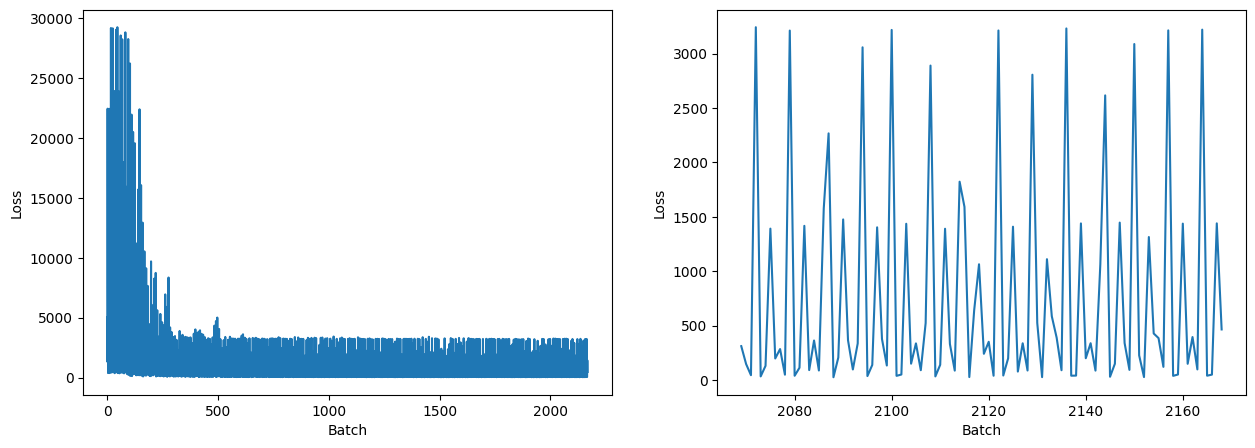

In [33]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(loss_train_list)
ax[0].set_xlabel('Batch')
ax[0].set_ylabel('Loss')
ax[1].plot(range(len(loss_train_list)-100,len(loss_train_list)),loss_train_list[-100:])
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Loss')
plt.savefig('Model_Loss.png')

# Evaluating Results

In [34]:
tensor_X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
tensor_y_valid = torch.tensor(y_valid.values, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    output = model(tensor_X_valid)
    valid_loss = LossFunction(output,tensor_y_valid)
    print(f"Validation loss = {valid_loss}")

Validation loss = 470.9053649902344


[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]


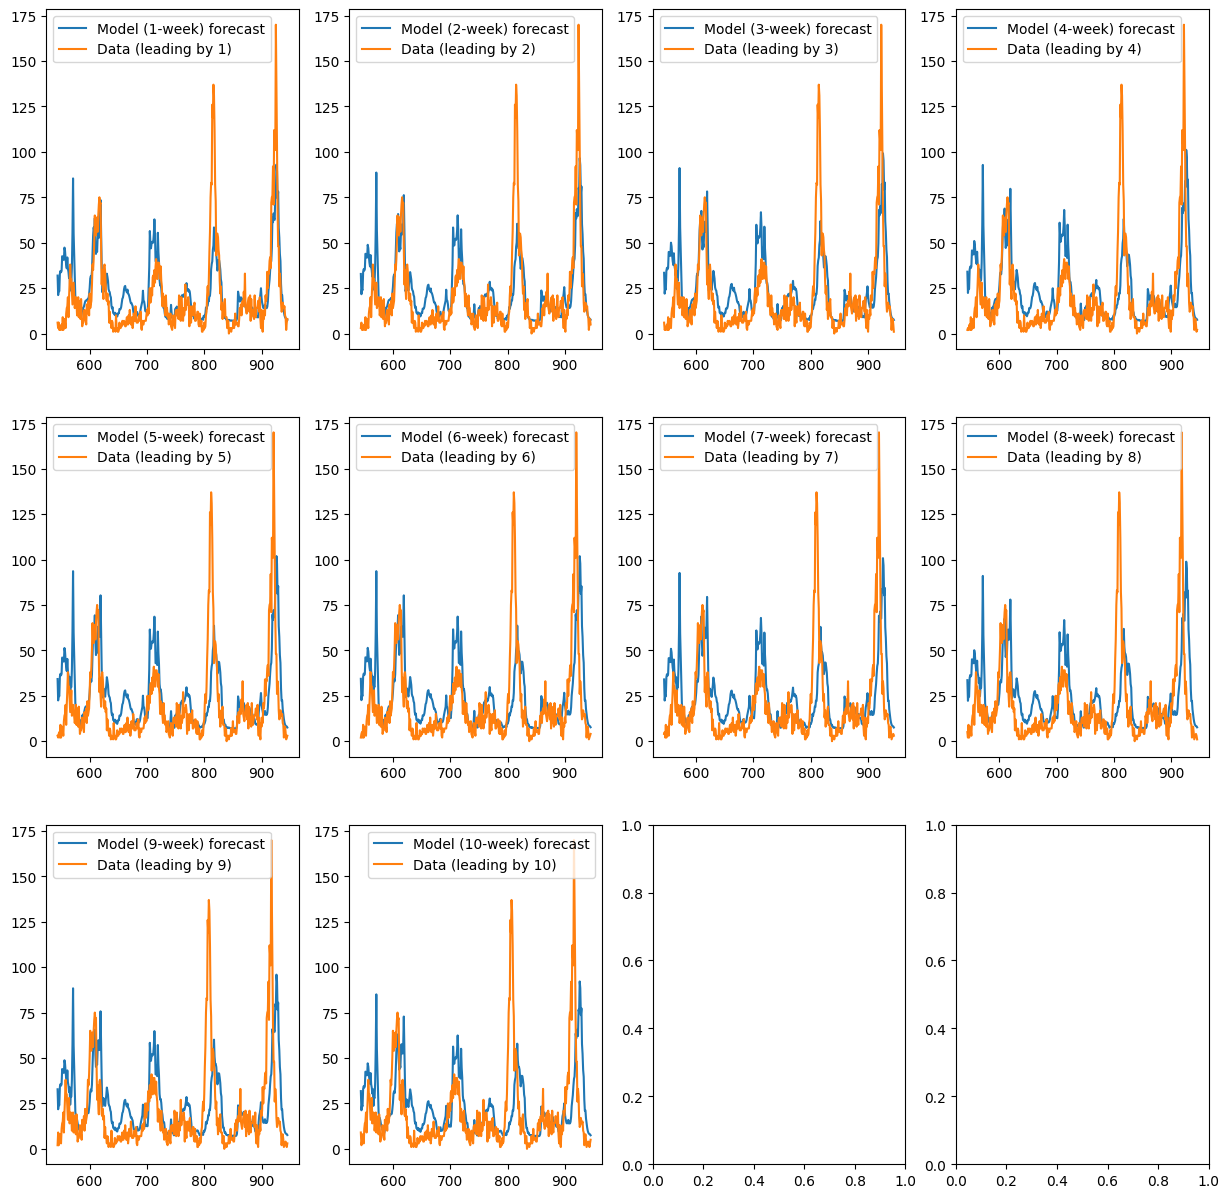

In [35]:
figure_num = 4
num_rows = 1 + num_target_lags // figure_num
num_cols = min(num_target_lags,figure_num)
fig, ax = plt.subplots(num_rows,num_cols,figsize=(15,5*num_rows))
print(ax)
step_index = 1

for step_index in range(0,num_target_lags):
    row_id = step_index // figure_num
    col_id = step_index % figure_num
    
    ax[row_id][col_id].plot(y_valid.index,output[:,step_index],label=f"Model ({step_index+1}-week) forecast")
    ax[row_id][col_id].plot(y_valid[f'y_step_{step_index+1}'],label=f"Data (leading by {step_index+1})")
    ax[row_id][col_id].legend()

plt.savefig('Model_Valid_Predictions.png')

In [36]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #preds.index = pd.period_range(start=date, periods=len(preds))
        preds.index = range(date,date+len(preds))
        preds.plot(ax=ax,label=f"Forecast from {date}")
    return ax

In [37]:

# Code to implement multistep plots
"""
EVERY = 20

START=50
END=550

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))
line1 = y_valid.loc[START:END].plot(ax=ax1,label='Data',color='black')

x=plot_multistep(output,ax=ax1,every=EVERY)
ax1.set_ylabel('Weekly Cases')
ax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])
"""

"\nEVERY = 20\n\nSTART=50\nEND=550\n\nfig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))\nline1 = y_valid.loc[START:END].plot(ax=ax1,label='Data',color='black')\n\nx=plot_multistep(output,ax=ax1,every=EVERY)\nax1.set_ylabel('Weekly Cases')\nax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])\n"

# Run a similar model without RNN

In [38]:
torch.manual_seed(0)
print(input_size,num_target_lags)
model2 = MyNetwork_Basic(input_size,num_target_lags).to(device)
print(model2)

21 10
MyNetwork_Basic(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [39]:
print(CountModelParameters(model2))

torch.Size([128, 21])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])
20618


In [40]:
#criterion = nn.MSELoss()
criterion = LossFunction
optimizer2 = optim.SGD(model2.parameters(), lr=0.0005)
scheduler2 = ExponentialLR(optimizer2, gamma=0.995)
num_epochs = 10

In [41]:
data_loader = MyDataLoader(X_train,y_train,batch_size=64,randomize_start=True)
num_batches = len(data_loader)
count = 0

debug_train = False

print_steps = 10
print_steps_batch = 1

num_epochs = 300

loss_train_list2 = []

for epoch in range(num_epochs):
    for batch_id, batch in enumerate(data_loader):
        data, label = batch
        
        data  = data.to(device)
        label = label.to(device)
        
        model2.train()
        
        output = model2(data)
        
        if (debug_train):
            print(output)
            print(label)
        
        loss = criterion(output,label)
        loss_train_list2.append(loss.item())
        
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        if (batch_id + 1) % (print_steps_batch) == 0:
            progress = 100.0 * batch_id / num_batches
            print(f"\tEpoch {epoch+1}, batch {batch_id + 1}. progress {progress:.2f}%, Loss: {loss.item():.4f}",end='\r')
            
    scheduler2.step() # try stepping the schedulear at the epoch level       
    if (epoch + 1) % print_steps == 0:
        print(f"\nEpoch {epoch+1}, Loss: {loss.item():.4f}")

	Epoch 10, batch 7. progress 75.00%, Loss: 482.2380
Epoch 10, Loss: 482.2380
	Epoch 20, batch 7. progress 75.00%, Loss: 3653.1226
Epoch 20, Loss: 3653.1226
	Epoch 30, batch 7. progress 75.00%, Loss: 847.2614
Epoch 30, Loss: 847.2614
	Epoch 40, batch 7. progress 75.00%, Loss: 1512.0844
Epoch 40, Loss: 1512.0844
	Epoch 50, batch 8. progress 87.50%, Loss: 460.5186
Epoch 50, Loss: 460.5186
	Epoch 60, batch 7. progress 75.00%, Loss: 3427.7278
Epoch 60, Loss: 3427.7278
	Epoch 70, batch 7. progress 75.00%, Loss: 408.1302
Epoch 70, Loss: 408.1302
	Epoch 80, batch 7. progress 75.00%, Loss: 3274.3953
Epoch 80, Loss: 3274.3953
	Epoch 90, batch 7. progress 75.00%, Loss: 1413.7635
Epoch 90, Loss: 1413.7635
	Epoch 100, batch 7. progress 75.00%, Loss: 3110.6394
Epoch 100, Loss: 3110.6394
	Epoch 110, batch 7. progress 75.00%, Loss: 356.8042
Epoch 110, Loss: 356.8042
	Epoch 120, batch 7. progress 75.00%, Loss: 2915.5879
Epoch 120, Loss: 2915.5879
	Epoch 130, batch 7. progress 75.00%, Loss: 316.7969
Epo

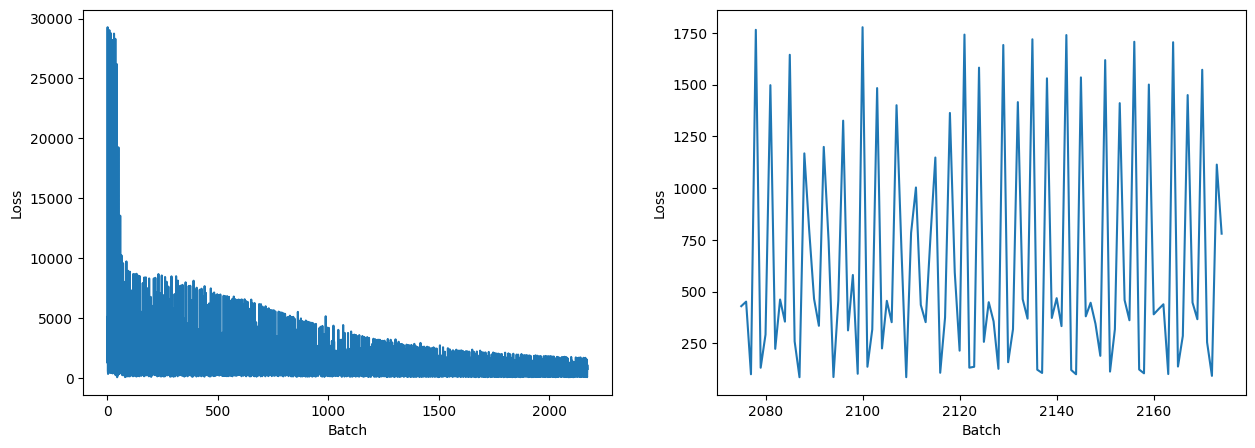

In [42]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(loss_train_list2)
ax[0].set_xlabel('Batch')
ax[0].set_ylabel('Loss')
ax[1].plot(range(len(loss_train_list2)-100,len(loss_train_list2)),loss_train_list2[-100:])
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Loss')
plt.savefig('Model2_Loss.png')

In [43]:
with torch.no_grad():
    model2.eval()
    output2 = model2(tensor_X_valid)
    valid_loss2 = LossFunction(output2,tensor_y_valid)
    print(f"Validation loss = {valid_loss2}")

Validation loss = 828.1619873046875


[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]


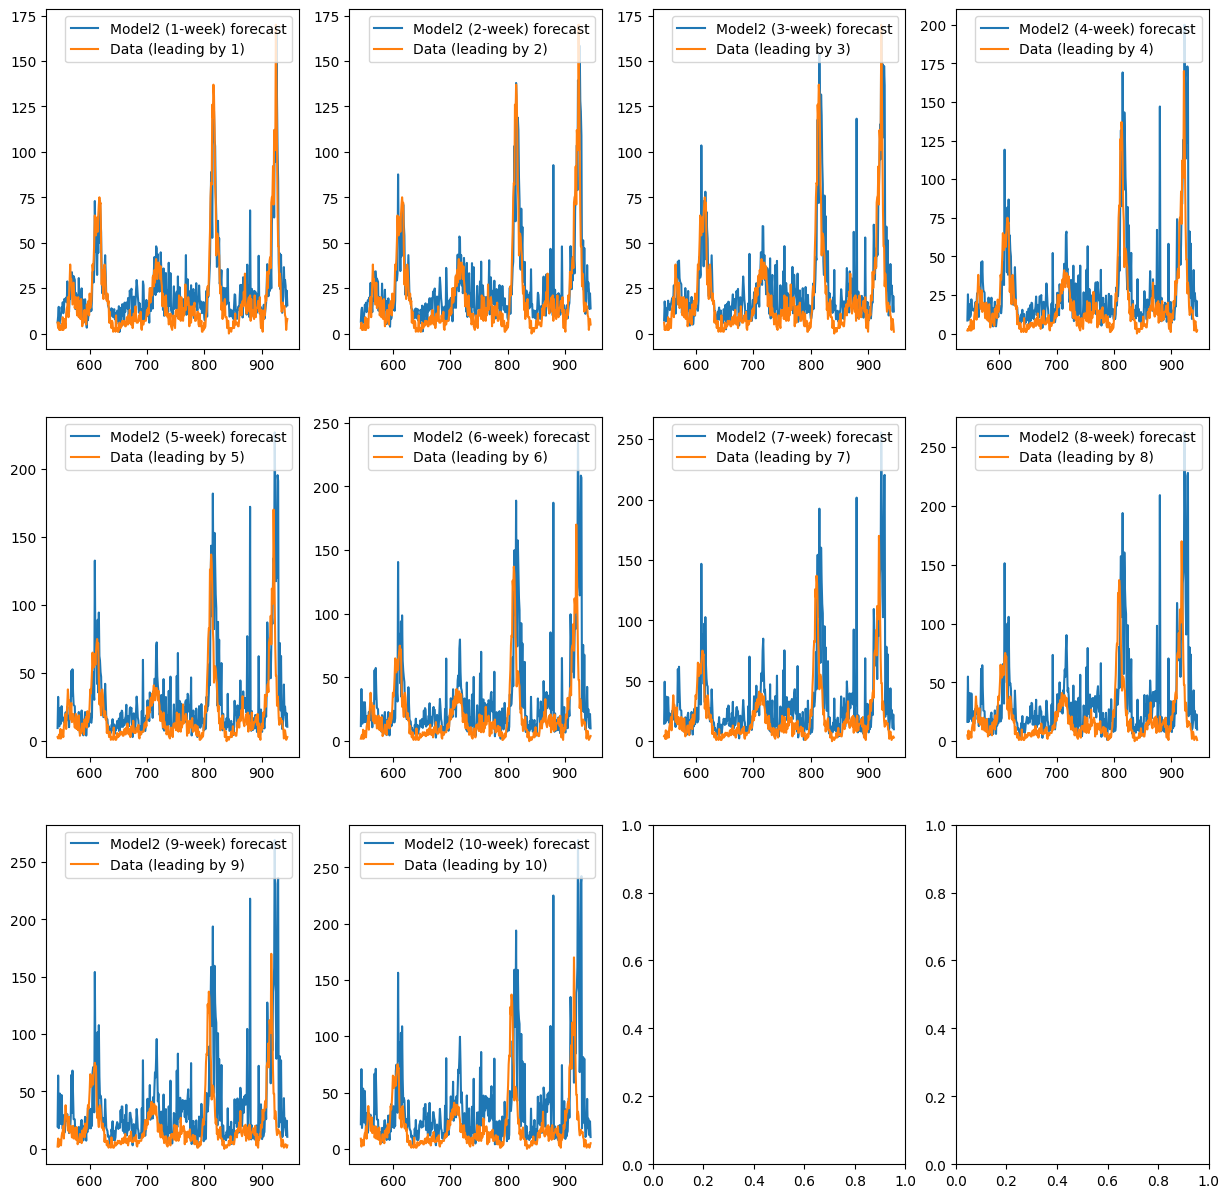

In [44]:
figure_num = 4
num_rows = 1 + num_target_lags // figure_num
num_cols = min(num_target_lags,figure_num)
fig, ax = plt.subplots(num_rows,num_cols,figsize=(15,5*num_rows))
print(ax)
step_index = 1

for step_index in range(0,num_target_lags):
    row_id = step_index // figure_num
    col_id = step_index % figure_num
    
    ax[row_id][col_id].plot(y_valid.index,output2[:,step_index],label=f"Model2 ({step_index+1}-week) forecast")
    ax[row_id][col_id].plot(y_valid[f'y_step_{step_index+1}'],label=f"Data (leading by {step_index+1})")
    ax[row_id][col_id].legend()

plt.savefig('Model2_Valid_Predictions.png')